In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler

%matplotlib inline
plt.style.use("paper.mplstyle")

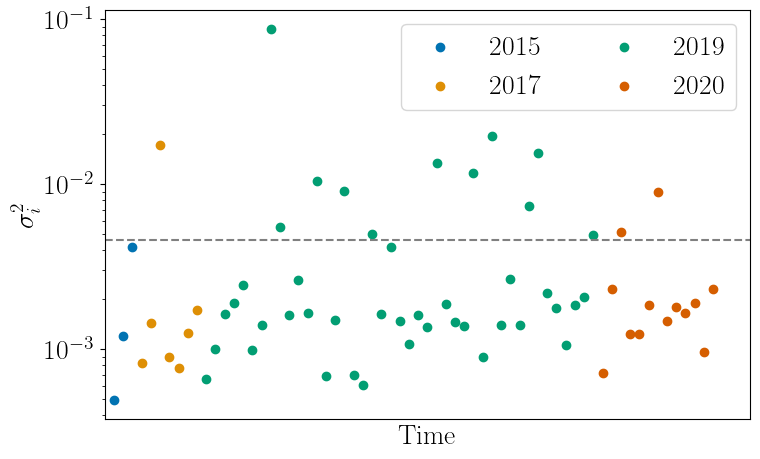

In [2]:
with open("per_event_sigmas.json", "rb") as ff:
    data = json.load(ff)
plt.figure(figsize=(8, 5))
plt.axhline(np.mean(list(data.values())), linestyle="--", color="gray")
for ii, (date, value) in enumerate(data.items()):
    plt.scatter(ii, value, color=f"C{(int(date) // 10000 - 14) // 2}")
for ii, year in enumerate([15, 17, 19, 20]):
    plt.scatter(-5, 0.01, color=f"C{ii}", label=f"20{year}")
plt.legend(loc="upper right", ncol=2)
plt.xticks([], [])
plt.xlabel("Time")
plt.ylabel("$\sigma^{2}_{i}$")
plt.yscale("log")
plt.xlim(-1, 69)
plt.tight_layout()
plt.savefig("figure-2.pdf")
plt.show()
plt.close()

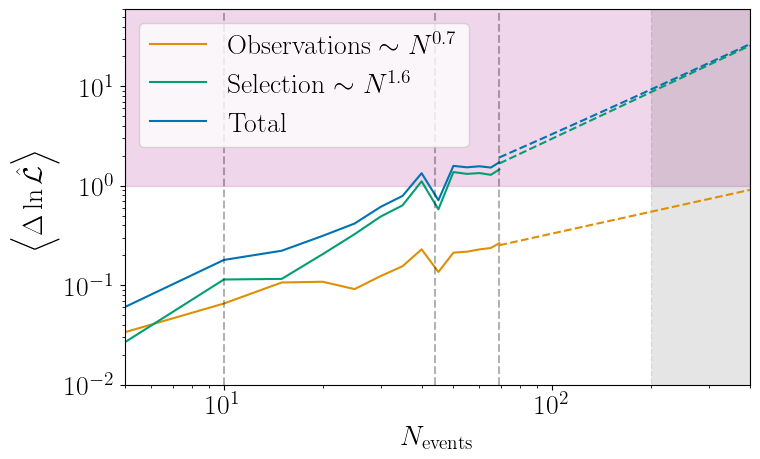

In [3]:
with open("n_events_uncertainty.json", "rb") as ff:
    data = json.load(ff)
n_events = np.array(data["n_events"])
event_term = np.array(data["event"])
selection_term = np.array(data["selection"])

logfn = np.log10
expfn = lambda x: 10**x

plt.figure(figsize=(8, 5))
plt.plot(n_events, event_term, color="C1", label=f"Observations $\\sim N^{{{np.polyfit(logfn(n_events), logfn(event_term), deg=1)[0]:.1f}}}$")
plt.plot(n_events, selection_term, color="C2", label=f"Selection $\\sim N^{{{np.polyfit(logfn(n_events), logfn(selection_term), deg=1)[0]:.1f}}}$")
plt.plot(n_events, event_term + selection_term, color="C0", label="Total")

plt.plot(
    np.linspace(69, 400, 1000),
    expfn(np.polyval(np.polyfit(logfn(n_events), logfn(selection_term), deg=1), logfn(np.linspace(69, 400, 1000))))
    + expfn(np.polyval(np.polyfit(logfn(n_events), logfn(event_term), deg=1), logfn(np.linspace(69, 400, 1000)))),
    linestyle="--",
    color="C0",
)
plt.plot(
    np.linspace(69, 400, 1000),
    expfn(np.polyval(np.polyfit(logfn(n_events), logfn(selection_term), deg=1), logfn(np.linspace(69, 400, 1000)))),
    linestyle="--",
    color="C2",
)
plt.plot(
    np.linspace(69, 400, 1000),
    expfn(np.polyval(np.polyfit(logfn(n_events), logfn(event_term), deg=1), logfn(np.linspace(69, 400, 1000)))),
    linestyle="--",
    color="C1",
)

plt.xscale("log")
plt.yscale("log")

plt.xlim(5, 400)
plt.ylim(1e-2, 60)
plt.xlabel("$N_{\\rm events}$")
plt.ylabel("$\\left\\langle \\Delta \\ln \\hat{\\cal L} \\right\\rangle$")
plt.axvline(10, color="k", linestyle="--", alpha=0.3)
plt.axvline(44, color="k", linestyle="--", alpha=0.3)
plt.axvline(69, color="k", linestyle="--", alpha=0.3)
xvals = np.arange(5, 400)
plt.fill_between(xvals, xvals**0, xvals**0 * 60, alpha=0.3, color="C4")
plt.fill_betweenx([0, 60], [200, 200], [max(xvals), max(xvals)], alpha=0.1, color="k", linestyle="--")
plt.legend(loc="upper left")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig("figure-3.pdf")
plt.show()
plt.close()

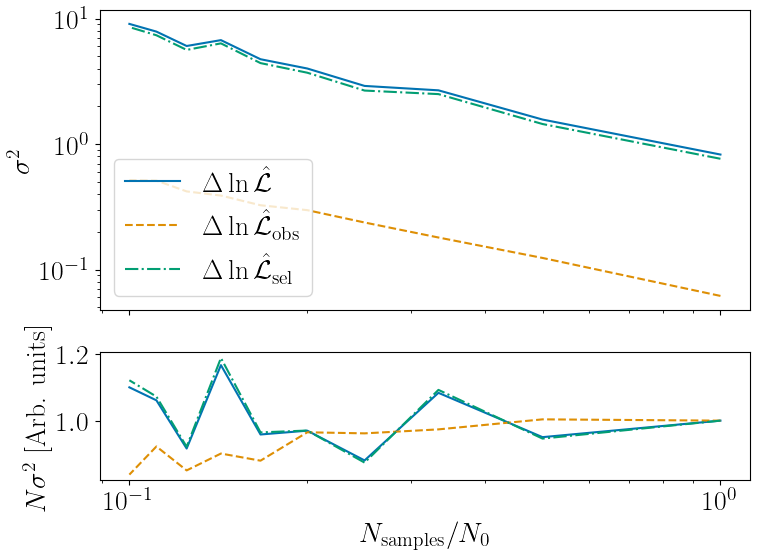

In [4]:
with open("n_samples_uncertainty.json", "rb") as ff:
    data = json.load(ff)

fractions = 1 / np.arange(1, 11)

fig, axes = plt.subplot_mosaic([["sigma"], ["sigma"], ["fraction"]], sharex=True, figsize=(8, 6))
axes["sigma"].set_xscale("log")
axes["sigma"].set_yscale("log")
axes["fraction"].set_xlabel("$N_{\\rm samples} / N_{0}$")
axes["sigma"].set_ylabel("$\\sigma^2$")
axes["fraction"].set_ylabel("$N \\sigma^2$ [Arb. units]")

idx = 0
kind = "cov"
label = "$\\Delta \\ln \\hat{\\cal L}"
yvals = np.array(data["cov"])
axes["fraction"].plot(fractions, yvals / yvals[0] * fractions, color=f"C{idx}")
axes["sigma"].plot(fractions, yvals, label=label + "$", color=f"C{idx}")

yvals = np.array(data["cov_pop"])
axes["fraction"].plot(fractions, yvals / yvals[0] * fractions, linestyle="--", color=f"C1")
axes["sigma"].plot(fractions, yvals, label=label + "_{\\rm obs}$", linestyle="--", color=f"C1")

yvals = np.array(data["cov_sel"])
axes["fraction"].plot(fractions, yvals / yvals[0] * fractions, linestyle="-.", color=f"C2")
axes["sigma"].plot(fractions, yvals, label=label + "_{\\rm sel}$", linestyle="-.", color=f"C2")
axes["sigma"].legend(loc="lower left")
plt.tight_layout()
plt.savefig("figure-4.pdf")
plt.show()
plt.close()